In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score

In [154]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['Weather'] = np.zeros((len(test),))

train_end_idx = len(train)
test_end_idx = len(test)

train = pd.concat([train, test], sort = False)

In [155]:
train.isnull().sum()

Date              14057
Loc               14117
TempLow           13918
TempHigh          13826
Steaming          13981
Sun               14046
WindDir           17389
WindSpeed         13834
DayWindDir        17874
NightWindDir      15448
DayWindSpeed      14029
NightWindSpeed    13928
DayHumidity       14056
NightHumidity     14056
DayPressure       13964
NightPressure     14104
DayCloud          13910
NightCloud        13936
DayTemp           14030
NightTemp         13937
Weather               0
RISK_MM           13871
dtype: int64

(70000, 22)


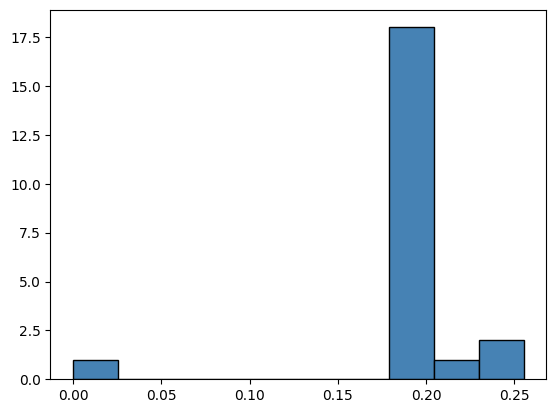

In [156]:
#train = train.drop(columns = 'RISK_MM')
naVariable = pd.isna(train).sum() / train.shape[0]
plt.hist(x = naVariable,
         bins = 10,
         color = 'steelblue',
         edgecolor = 'black'
         )
print(train.shape)

In [157]:
#train['Date'] = pd.to_datetime(train['Date'])
#train['Year'] = train['Date'].dt.year
#train['Month'] = train['Date'].dt.month
#train['Day'] = train['Date'].dt.day
#train = train.drop(columns = 'Date')
#train = train.drop(columns = 'RISK_MM')
train = pd.concat([train, pd.get_dummies(train['Loc'])], axis = 1)
train = pd.concat([train, pd.get_dummies(train['WindDir'], prefix = 'WindDir')], axis = 1)
train = pd.concat([train, pd.get_dummies(train['DayWindDir'], prefix = 'DayWindDir')], axis = 1)
train = pd.concat([train, pd.get_dummies(train['NightWindDir'], prefix = 'NightWindDir')], axis = 1)

'''
for nominal in list(train.dtypes[train.dtypes == object].index):
    class_mapping = {label:idx for idx,label in enumerate(set(train[nominal]))}
    train[nominal] = train[nominal].map(class_mapping)
train = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
'''


'\nfor nominal in list(train.dtypes[train.dtypes == object].index):\n    class_mapping = {label:idx for idx,label in enumerate(set(train[nominal]))}\n    train[nominal] = train[nominal].map(class_mapping)\ntrain = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))\n'

In [158]:

from sklearn.impute import SimpleImputer
# 將非數值欄位拿掉
train = train.drop(columns = [col for col in train.columns if train[col].dtype == object])

imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(train.values)
imputed_data = imr.transform(train.values)

df_impute = pd.DataFrame(imputed_data)
df_impute.columns = train.columns

train = df_impute

train.to_csv('aftertrain.csv')

In [159]:
#train = train.drop(labels = train.columns[train.corr()['Weather'].abs() < 0.05], axis = 1)

In [1]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    train.drop(columns = ['Weather']).values[:train_end_idx, :],
    train['Weather'].values[:train_end_idx], test_size = 0.5)

'''
X_train = train.drop(columns = ['Weather']).values[:train_end_idx, :]
Y_train = train['Weather'].values[:train_end_idx]
'''

X_test = train.drop(columns = ['Weather']).values[train_end_idx:, :]

NameError: name 'train' is not defined

In [161]:
#X_train, Y_train = RandomUnderSampler().fit_resample(X_train, Y_train)
#X_train, Y_train = SMOTE().fit_resample(X_train, Y_train)
X_train, Y_train = SMOTEENN().fit_resample(X_train, Y_train)
#X_train, Y_train = SMOTETomek().fit_resample(X_train, Y_train)


In [162]:
#資料標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test = sc.transform(X_test)

In [163]:
#PCA降維
'''
pca = PCA(n_components = 2)
X_train_std = pca.fit_transform(X_train_std)
X_val_std = pca.transform(X_val_std)
X_test = pca.transform(X_test)
'''

'\npca = PCA(n_components = 2)\nX_train_std = pca.fit_transform(X_train_std)\nX_val_std = pca.transform(X_val_std)\nX_test = pca.transform(X_test)\n'

In [164]:
'''
from sklearn.neural_network import MLPClassifier
model= MLPClassifier(alpha = 1e-5, hidden_layer_sizes = (50, 50))
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('NeuralNetwork.csv',  index_label = 'Id')
'''

"\nfrom sklearn.neural_network import MLPClassifier\nmodel= MLPClassifier(alpha = 1e-5, hidden_layer_sizes = (50, 50))\nmodel.fit(X_train_std, Y_train)\n\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('NeuralNetwork.csv',  index_label = 'Id')\n"

In [165]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('RandomForest.csv',  index_label = 'Id')
'''
print('特徵重要程度: ',model.feature_importances_)

correlation = train.corr()
influence_order=correlation['Weather'].sort_values(ascending=
False)
influence_order_abs = abs(correlation['Weather'].sort_values(
ascending=False))
print(influence_order)
print(influence_order_abs)
'''


Accuracy: 0.848731
f1-score: 0.421076


"\nprint('特徵重要程度: ',model.feature_importances_)\n\ncorrelation = train.corr()\ninfluence_order=correlation['Weather'].sort_values(ascending=\nFalse)\ninfluence_order_abs = abs(correlation['Weather'].sort_values(\nascending=False))\nprint(influence_order)\nprint(influence_order_abs)\n"

In [166]:
'''
from sklearn import svm

model = svm.SVC(kernel = 'rbf', C = 2, random_state = 0) 
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('SVM.csv',  index_label = 'Id')
'''

"\nfrom sklearn import svm\n\nmodel = svm.SVC(kernel = 'rbf', C = 2, random_state = 0) \nmodel.fit(X_train_std, Y_train)\n\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('SVM.csv',  index_label = 'Id')\n"

In [167]:
'''
from sklearn.svm import SVC

model = SVC(kernel='linear', C=2) 
model.fit(X_train_std, Y_train) 

#predict
y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('LinearSVM.csv',  index_label = 'Id')
'''

"\nfrom sklearn.svm import SVC\n\nmodel = SVC(kernel='linear', C=2) \nmodel.fit(X_train_std, Y_train) \n\n#predict\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('LinearSVM.csv',  index_label = 'Id')\n"

In [168]:
'''
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators = 100, random_state = 0)
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('AdaBoost.csv',  index_label = 'Id')
'''

"\nfrom sklearn.ensemble import AdaBoostClassifier\n\nmodel = AdaBoostClassifier(n_estimators = 100, random_state = 0)\nmodel.fit(X_train_std, Y_train)\n\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('AdaBoost.csv',  index_label = 'Id')\n"

In [169]:
'''
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('Bagging.csv',  index_label = 'Id')
'''

"\nfrom sklearn.ensemble import BaggingClassifier\n\nmodel = BaggingClassifier()\nmodel.fit(X_train_std, Y_train)\n\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('Bagging.csv',  index_label = 'Id')\n"

In [170]:
'''
from sklearn.tree import DecisionTreeClassifier

#train tree model
model = DecisionTreeClassifier()
model.fit(X_train_std, Y_train)

#predict
y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('DecisionTree.csv',  index_label = 'Id')
'''

"\nfrom sklearn.tree import DecisionTreeClassifier\n\n#train tree model\nmodel = DecisionTreeClassifier()\nmodel.fit(X_train_std, Y_train)\n\n#predict\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('DecisionTree.csv',  index_label = 'Id')\n"

In [171]:

'''
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 5, p = 2)
model.fit(X_train_std, Y_train)

y_pred_decision = model.predict(X_val_std)
print('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))
print('f1-score: %f' % f1_score(Y_val, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('KNeighbors.csv',  index_label = 'Id')
'''

"\nfrom sklearn.neighbors import KNeighborsClassifier\nmodel = KNeighborsClassifier(n_neighbors = 5, p = 2)\nmodel.fit(X_train_std, Y_train)\n\ny_pred_decision = model.predict(X_val_std)\nprint('Accuracy: %f' % accuracy_score(Y_val, y_pred_decision))\nprint('f1-score: %f' % f1_score(Y_val, y_pred_decision))\n\nans_pred = model.predict(X_test)\ndf_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])\ndf_sap.to_csv('KNeighbors.csv',  index_label = 'Id')\n"